In [1]:
import mobster as mb

In [2]:
data = mb.load_example_data("./")

In [11]:
fitted = mb.fit_mobster(data, 1,1, max_it = 500, lr = 0.01)

Running MOBSTER on 3 karyotypes with 1 subclones.
Fitting a model with tail
Computing cluster assignements.
Computing information criteria.
Done!


ELBO: -5666.935851319  : 100%|██████████| 500/500 [00:15<00:00, 33.10it/s]


In [4]:
fitted['model_parameters']['1:1']

{'cluster_probs': array([[1.27187455e-02, 1.00000000e+00, 1.00000000e+00, ...,
         9.43935037e-01, 1.00000000e+00, 1.23976208e-02],
        [8.19658041e-01, 5.62425748e-30, 0.00000000e+00, ...,
         9.38455760e-03, 3.50324616e-44, 7.99646020e-01],
        [1.67623267e-01, 1.80219388e-22, 2.33372750e-35, ...,
         4.66802977e-02, 2.63497675e-33, 1.87956423e-01]], dtype=float32),
 'cluster_assignments': array([1, 0, 0, ..., 0, 0, 1]),
 'mixture_probs': array([0.29981396, 0.54862666, 0.15155938], dtype=float32),
 'beta_concentration1': array([69.92184982, 53.4694929 ]),
 'beta_concentration2': array([79.41523209, 65.11443044]),
 'tail_shape': array(0.74816096, dtype=float32),
 'tail_scale': 0.044045046}

In [12]:
from scipy.stats import beta, pareto
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def plot_results(data, inf_res, bins=50, output = "results.png",fig_height = 10, fig_width = 8,tail=True):

    all_params = inf_res["model_parameters"]
    plt.rcParams["figure.figsize"] = (fig_height, fig_width)
    tail = inf_res['run_parameters']['tail']
    fig, axs = plt.subplots(3)
    for i, kr in enumerate(data):

        axs[i].hist(data[kr].detach().numpy(), bins=bins, density=True, alpha=0.48)
        params = all_params[kr]

        karyos = list(data.keys())

        major = [int(str(i).split(":")[0]) for i in karyos]
        minor = [int(str(i).split(":")[1]) for i in karyos]
        theoretical_num_clones = [1 if (mn == 0 or mn == mj) else 2 for mj, mn in zip(major, minor)]
        assignment_probs = params["mixture_probs"]

        for j in range(tail, len(assignment_probs)):

            if theoretical_num_clones[i] == 1:
                cl = "tab:green" if (j - tail) < 1 else "tab:red"

            else:
                cl = "tab:green" if (j - tail) < 2 else "tab:red"

            a = params["beta_concentration1"][j - tail]
            b = params["beta_concentration2"][j - tail]

            x = np.linspace(0.05, 1, 200)

            p = beta.pdf(x, a, b) * assignment_probs[j]


            axs[i].plot(x, p, linewidth=3, color=cl)

        if tail == 1:
            alpha = params["tail_shape"]
            x = np.linspace(0.05, 1, 200)
            p = pareto.pdf(x, alpha, scale=params["tail_scale"]) * assignment_probs[0]
            axs[i].plot(x, p, linewidth=3, color="tab:pink")


    pink_patch = mpatches.Patch(color='tab:pink', label='Tail')
    red_patch = mpatches.Patch(color='tab:red', label='Subclonal')
    green_patch = mpatches.Patch(color='tab:green', label='Clonal')

    plt.legend(handles=[pink_patch, red_patch, green_patch])

    plt.savefig(output, dpi=300)

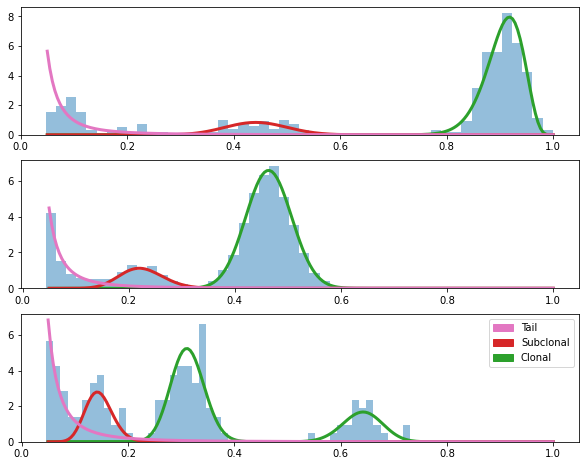

In [14]:
plot_results(data, fitted, output= "cane.png")